## Setting the correct path

In [1]:
import os

model_path = os.path.join(os.getcwd(), 'saved_models')
cifar_working_dir = os.path.dirname(os.path.dirname(model_path))
src_path = os.path.dirname(os.path.dirname(cifar_working_dir))
explanation_path = os.path.join(os.path.dirname(model_path), 'explanation_files')
explanation_heatmap_path = os.path.join(os.path.dirname(model_path), 'explanation_heatmaps')
sanity_checks_output = os.path.join(os.path.join(os.getcwd(), 'sanity_checks'))


print('model_path ', model_path)
print('cifar_working_path ', cifar_working_dir)
print('src_path ', src_path)
print('explanation_path ', explanation_path)
print('explanation_heatmap_path ', explanation_heatmap_path)
print('sanity_checks folder ', sanity_checks_output)

model_path  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\saved_models
cifar_working_path  D:\Mihir\MT\Code\cifar\GBP_explanation
src_path  D:\Mihir\MT\Code
explanation_path  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\explanation_files
explanation_heatmap_path  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\explanation_heatmaps
sanity_checks folder  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\sanity_checks


## Imports

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import re
import time
import cv2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import seaborn as sns
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,src_path)

from src.utils import *

np.set_printoptions(suppress=True)

2.8.0
Eager execution enabled : True


## Load data

In [3]:
(x_train, y_train), (x_test, y_test), train_generator, validation_generator, test_generator = load_cifar(num_classes = 10,
val_split = 0.95,
rotation_range = 0.2,
width_shift_range = 0.1, 
height_shift_range = 0.1,
shear_range = 0.1,
zoom_range = 0.1 ,
horizontal_flip = True ,
vertical_flip = False,
rescale = 1/255.,
train_batch_size=1024, 
val_batch_size=1024,
test_batch_size=1024)


# these sets are to be shuffled
y_train_shuffled = np.argmax(y_train, axis=1)
y_test_shuffled = np.argmax(y_test, axis=1)

print('original train labels \n ', y_train)
print('original train shape \n ', y_train.shape)
print('original test labels \n ', y_test)
print('original test labels \n ', y_test.shape)

np.random.shuffle(y_train_shuffled)
np.random.shuffle(y_test_shuffled)

print('shuffled train labels \n ', y_train_shuffled)
print('shuffled train shape \n ', y_train_shuffled.shape)
print('shuffled test labels \n ', y_test_shuffled)
print('shuffled test labels \n ', y_test_shuffled.shape)

# convert the shuffled labels to one hot encoding again 
y_train_shuffled = to_categorical(y_train_shuffled, num_classes=10)
y_test_shuffled = to_categorical(y_test_shuffled, num_classes=10)

number of examples in train generator  50000
number of examples in val generator  9500
number of examples in test generator  500
original train labels 
  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
original train shape 
  (50000, 10)
original test labels 
  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
original test labels 
  (10000, 10)
shuffled train labels 
  [6 2 2 ... 6 4 4]
shuffled train shape 
  (50000,)
shuffled test labels 
  [4 4 6 ... 4 8 5]
shuffled test labels 
  (10000,)


## Class definitions : StochasticModel & StochasticClassifier

In [4]:
import numpy as np
import tensorflow as tf 
import tensorflow.keras.backend as K

Layer = tf.keras.layers.Layer
Dropout = tf.keras.layers.Dropout

class StochasticDropout(Dropout):
    """
        Applies Dropout to the input, independent of the training phase.
        Used to easily implement MC-Dropout. It is a drop-in replacement for
        the standard Keras Dropout layer, but note that this layer applies
        dropout at the training and inference phases.
    """
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super(StochasticDropout, self).__init__(rate, noise_shape, seed, **kwargs)
    
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            return K.dropout(inputs, self.rate, noise_shape, seed=self.seed)

        return inputs

    def get_config(self):
        # this code is added so that the model can be saved even after making use of a custom layer 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        config = super(StochasticDropout, self).get_config()
        config.update({'rate': self.rate})
        return config


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
        

class StochasticClassifier(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output

    #essentially equivalent to call  
    def __call__(self, inp, num_samples=None, **kwargs):
        """
            Performs a prediction given input inp using MC Dropout, and returns the averaged probabilities of model output.
        """
        samples = self.predict_samples(inp, num_samples, **kwargs)
        mean_probs = np.mean(samples, axis=0)
        print('in call function')
        mean_probs = mean_probs / np.sum(mean_probs, axis=1, keepdims=True)

        return samples, mean_probs


    def predict_output(self, inp, num_samples=None, batch_size=32, **kwargs):
        """
            Performs a prediction given input inp using MC Dropout, and returns the averaged probabilities of model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        print('Intermediate sample shape ', samples.shape)
        mean_probs = np.mean(samples, axis=0)
        mean_probs = mean_probs / np.sum(mean_probs, axis=1, keepdims=True)
        print('Inside the predict_output() of stochasticclassifier class')

        return samples, mean_probs

    def save(self, path):
        # stochaticmodel class does not have basic tf function like save(), summary(), get_layer() and so on 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

## CIFAR10 class map

In [5]:
cifar_class_map = {0:'airplane',
                   1:'automobile',
                   2:'bird',
                   3:'cat',
                   4:'deer',
                   5:'dog',
                   6:'frog',
                   7:'horse',
                   8:'ship',
                   9:'truck'}

## Load the trained model

In [6]:
# error if the custom object containing the stochastic dropout model not passed (Unknown layer: StochasticDropout. Please ensure this object is passed to the `custom_objects` argument)

#import os
#test = os.listdir(model_path)
#model_checkpoints = []
#model_name = []

#for item in test:
#    if item.endswith('.h5'):
#        print('model name : ', item)
#        model_name.append(item)
        
#print(model_name)
#print(sorted(model_name))
#best_model_path = model_name[-1]  # model naming template has the third element as epochs, save best will save the highest best performing epoch
#print('best model path \n', best_model_path)
#trained_model = tf.keras.models.load_model(os.path.join(model_path,item), 
#                                   custom_objects={'StochasticDropout':StochasticDropout})

#trained_model.summary()

## Define model

In [7]:
'''
def minivgg_dropout(input_shape, prob=0.25):
    model = Sequential()
    model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu', 
                   padding='same', 
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, 
                     kernel_size=(3, 3), 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, 
                     kernel_size=(3, 3), 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(StochasticDropout(prob))
    model.add(Dense(256, activation='relu'))
    model.add(StochasticDropout(prob))
    model.add(Dense(10, activation='softmax'))
    
    return model
'''

"\ndef minivgg_dropout(input_shape, prob=0.25):\n    model = Sequential()\n    model.add(Conv2D(64, \n                     kernel_size=(3, 3), \n                     activation='relu', \n                   padding='same', \n                     input_shape=input_shape))\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D((2, 2)))\n\n    model.add(Conv2D(128, \n                     kernel_size=(3, 3), \n                     padding='same', \n                     activation='relu'))\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D((2, 2)))\n\n    model.add(Conv2D(128, \n                     kernel_size=(3, 3), \n                     padding='same', \n                     activation='relu'))\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D((2, 2)))\n    \n    model.add(Flatten())\n    model.add(StochasticDropout(prob))\n    model.add(Dense(256, activation='relu'))\n    model.add(StochasticDropout(prob))\n    model.add(Dense(10, activation='soft

## Train the model (intentionally with incorrect labels)

In [8]:
def minivgg_dropout(input_shape, prob=0.25):
    model = Sequential()
    model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu', 
                     padding='same', 
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, 
                     kernel_size=(3, 3), 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, 
                     kernel_size=(3, 3), 
                     padding='same', 
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(StochasticDropout(prob))
    model.add(Dense(256, activation='relu'))
    model.add(StochasticDropout(prob))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

Epoch 1/200
19/19 [==============================] - 6s 170ms/step - loss: 3.0988 - accuracy: 0.0974 - val_loss: 2.3163 - val_accuracy: 0.1018
Epoch 2/200
19/19 [==============================] - 2s 89ms/step - loss: 2.3095 - accuracy: 0.1003 - val_loss: 2.6439 - val_accuracy: 0.1007
Epoch 3/200
19/19 [==============================] - 2s 90ms/step - loss: 2.3033 - accuracy: 0.1039 - val_loss: 2.8338 - val_accuracy: 0.1002
Epoch 4/200
19/19 [==============================] - 2s 90ms/step - loss: 2.3024 - accuracy: 0.1041 - val_loss: 2.7929 - val_accuracy: 0.0994
Epoch 5/200
19/19 [==============================] - 2s 90ms/step - loss: 2.3021 - accuracy: 0.1055 - val_loss: 2.7127 - val_accuracy: 0.1004
Epoch 6/200
19/19 [==============================] - 2s 90ms/step - loss: 2.3025 - accuracy: 0.1034 - val_loss: 2.6069 - val_accuracy: 0.0976
Epoch 7/200
19/19 [==============================] - 2s 89ms/step - loss: 2.3013 - accuracy: 0.1069 - val_loss: 2.5159 - val_accuracy: 0.0994
Epoch

19/19 [==============================] - 2s 90ms/step - loss: 1.3011 - accuracy: 0.5359 - val_loss: 3.6739 - val_accuracy: 0.1024
Epoch 59/200
19/19 [==============================] - 2s 89ms/step - loss: 1.2682 - accuracy: 0.5499 - val_loss: 3.6547 - val_accuracy: 0.1024
Epoch 60/200
19/19 [==============================] - 2s 90ms/step - loss: 1.2414 - accuracy: 0.5594 - val_loss: 4.1101 - val_accuracy: 0.1036
Epoch 61/200
19/19 [==============================] - 2s 89ms/step - loss: 1.2146 - accuracy: 0.5702 - val_loss: 4.1095 - val_accuracy: 0.1042
Epoch 62/200
19/19 [==============================] - 2s 89ms/step - loss: 1.1920 - accuracy: 0.5756 - val_loss: 3.8057 - val_accuracy: 0.1005
Epoch 63/200
19/19 [==============================] - 2s 90ms/step - loss: 1.1662 - accuracy: 0.5870 - val_loss: 3.7611 - val_accuracy: 0.0981
Epoch 64/200
19/19 [==============================] - 2s 90ms/step - loss: 1.1355 - accuracy: 0.6007 - val_loss: 3.6821 - val_accuracy: 0.0988
Epoch 65/200

19/19 [==============================] - 2s 90ms/step - loss: 0.5447 - accuracy: 0.8142 - val_loss: 5.1986 - val_accuracy: 0.1002
Epoch 116/200
19/19 [==============================] - 2s 90ms/step - loss: 0.5415 - accuracy: 0.8143 - val_loss: 4.8714 - val_accuracy: 0.1016
Epoch 117/200
19/19 [==============================] - 2s 90ms/step - loss: 0.5392 - accuracy: 0.8162 - val_loss: 5.1344 - val_accuracy: 0.0990
Epoch 118/200
19/19 [==============================] - 2s 90ms/step - loss: 0.5303 - accuracy: 0.8173 - val_loss: 5.5159 - val_accuracy: 0.0989
Epoch 119/200
19/19 [==============================] - 2s 90ms/step - loss: 0.5222 - accuracy: 0.8216 - val_loss: 4.8278 - val_accuracy: 0.1002
Epoch 120/200
19/19 [==============================] - 2s 90ms/step - loss: 0.5156 - accuracy: 0.8240 - val_loss: 5.3995 - val_accuracy: 0.1013
Epoch 121/200
19/19 [==============================] - 2s 91ms/step - loss: 0.5139 - accuracy: 0.8239 - val_loss: 5.1945 - val_accuracy: 0.1030
Epoch 

Epoch 172/200
19/19 [==============================] - 2s 90ms/step - loss: 0.3822 - accuracy: 0.8709 - val_loss: 6.4267 - val_accuracy: 0.1010
Epoch 173/200
19/19 [==============================] - 2s 90ms/step - loss: 0.3687 - accuracy: 0.8753 - val_loss: 6.1461 - val_accuracy: 0.1010
Epoch 174/200
19/19 [==============================] - 2s 90ms/step - loss: 0.3729 - accuracy: 0.8725 - val_loss: 6.3482 - val_accuracy: 0.0998
Epoch 175/200
19/19 [==============================] - 2s 89ms/step - loss: 0.3704 - accuracy: 0.8751 - val_loss: 6.0170 - val_accuracy: 0.1015
Epoch 176/200
19/19 [==============================] - 2s 90ms/step - loss: 0.3505 - accuracy: 0.8798 - val_loss: 6.1502 - val_accuracy: 0.1061
Epoch 177/200
19/19 [==============================] - 2s 90ms/step - loss: 0.3651 - accuracy: 0.8782 - val_loss: 6.0497 - val_accuracy: 0.1005
Epoch 178/200
19/19 [==============================] - 2s 90ms/step - loss: 0.3641 - accuracy: 0.8786 - val_loss: 6.0073 - val_accuracy:

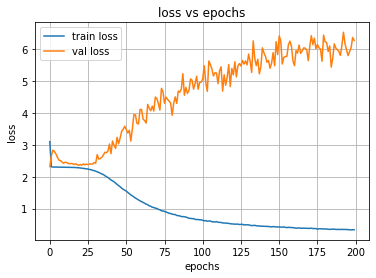

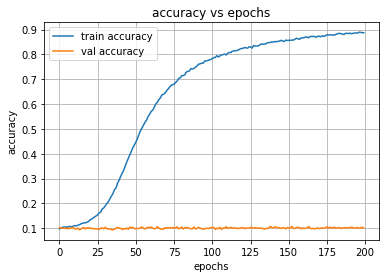

In [9]:
epochs=200
num_samples=10 
prob=0.25
random_model = minivgg_dropout(input_shape=x_train.shape[1:], prob=prob)

history = random_model.fit(x_train, 
                                     y_train_shuffled,
                                     batch_size=2048,
                                     validation_split=0.25,
                                     validation_batch_size=2048,
                                     epochs=epochs)

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss vs epochs')
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy vs epochs')
plt.show()


random_model.save(os.path.join(os.getcwd(), 'randomized_model.h5'))

## GBP Logic

In [10]:
'''
def guided_bp(test_input, test_label, model, layer_name):
    @tf.custom_gradient
    def guidedRelu(x):
        #https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
        def grad(dy):
            return tf.cast(dy>0,'float32') * tf.cast(x>0, 'float32') * dy
        return tf.nn.relu(x), grad

    normalized_gb_list = [] # collect the noramlized heatmaps of all the samples in a list 
    predicted_class_list = [] # to collect the prediction of all the samples in a list 
    LAYER_NAME = layer_name

    # create a model till last convolutional layers to have the best compromise between high-level semantics and detailed spatial information
    gb_model = tf.keras.models.Model(inputs = [model.input],    
                                     outputs = [model.get_layer(LAYER_NAME).output])
    
    #print('list of gbp_model layer name : ')
    #for i in gb_model.layers:
    #    print('layer_name_ ', i.name)
    
    #gb_model.summary()
    
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    #value = model.get_layer(LAYER_NAME).output.shape[-1]  # to compute the number of channels in the volume at a particular layer 

    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu


    with tf.GradientTape() as tape:
        inputs = tf.cast(test_input, tf.float32)
        tape.watch(inputs)

        #outputs = gb_model.predict(inputs) 
        outputs = gb_model(inputs)
        #print('model prediction vector \n', outputs)
        #print('model prediction ', np.argmax(outputs))
        # essentially model() and model.predict() yield the same output with the difference that 
        # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-keras#:~:text=The%20format%20may%20be%20different,its%20structure%2C%20weights%20and%20biases.
        #Today given a model in tensorflow 2.0 (built using the keras library), #out_np = model.predict(x) provides a numpy array which can, as an example, be printed with print(out_np).
        #On the other hand,out_tf = model(x) results into a tensorflow object, wich can be converted to a numpy array with .numpy()
        
        predicted_class = np.argmax(outputs)
        max_of_predicted_logits = outputs[:, predicted_class]
        #print('max of predicted logits : ', max_of_predicted_logits)
        print('prediction : ', predicted_class)
        print('GT : ', np.argmax(test_label))
        
        class_label = np.argmax(test_label)
        desired_class_logit = outputs[:, class_label]
        
    #print('outputs[:, predicted_class] : ', outputs[:, predicted_class])
    grads = tape.gradient(max_of_predicted_logits, inputs)[0]# selecting that unit in dense layer that has the maximum activation for a given input,,,, if[0] not selected then shape of grads is: [1,32,32,3] 
    #grads = tape.gradient(desired_class_logit, inputs)[0]
    #print('grads shape : \n', grads.shape)

    return grads, predicted_class
'''

"\ndef guided_bp(test_input, test_label, model, layer_name):\n    @tf.custom_gradient\n    def guidedRelu(x):\n        #https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57\n        def grad(dy):\n            return tf.cast(dy>0,'float32') * tf.cast(x>0, 'float32') * dy\n        return tf.nn.relu(x), grad\n\n    normalized_gb_list = [] # collect the noramlized heatmaps of all the samples in a list \n    predicted_class_list = [] # to collect the prediction of all the samples in a list \n    LAYER_NAME = layer_name\n\n    # create a model till last convolutional layers to have the best compromise between high-level semantics and detailed spatial information\n    gb_model = tf.keras.models.Model(inputs = [model.input],    \n                                     outputs = [model.get_layer(LAYER_NAME).output])\n    \n    #print('list of gbp_model layer name : ')\n    #for i in gb_model.layers:\n    #    print('layer_name_ ', i.name)\n    \n    #gb_model.su

## IG Logic

In [11]:
'''
class IntegratedGradient:
    def visualize_input_to_be_explained(self, test_input, test_label):
        # source : https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

        # selecting a sample to explain 
        #test_sample_index=np.random.randint(3000)
        #test_input_temp = x_test[test_sample_index]
        #test_input_temp_norm = test_input_temp/255.0

        #print('image pixel values ', test_input_temp_norm)
        #test_label = y_test[test_sample_index]
        #test_label_string = cifar_class_map.get(np.argmax(test_label))
        #ground_truth = np.argmax(test_label)

        # show the selected sample
        #plt.subplot(121)
        #plt.imshow(test_input)
        #plt.title('GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
      
        #test_input = tf.expand_dims(test_input_temp, axis=0)

        # plot the baseline
        baseline = np.zeros(shape=(32,32,3))  # shape similar to that of input 

        #plt.subplot(122)
        #plt.imshow(baseline)
        #plt.title("Baseline")
        #plt.axis('off')
        #plt.show()
        return baseline


    def generating_interpolated_images(self, baseline, image, m_steps):
        # generating interpolated images
        m_steps=m_steps
        alphas = np.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.
        alphas_x = alphas[:, np.newaxis, np.newaxis, np.newaxis]

        baseline_x = np.expand_dims(baseline, axis=0)
        baseline_x = np.ndarray.astype(baseline_x, dtype=np.float32)

        input_x = np.expand_dims(image, axis=0)
        input_x = np.ndarray.astype(input_x, dtype=np.float32)

        delta = input_x - baseline_x
        images = baseline_x +  alphas_x * delta
        return alphas, images


    def visualize_interpolated_images(self, alphas, images):
        #convert numpy images to tensor
        #interpolated_images_tensor = tf.convert_to_tensor(interpolated_images)
        fig = plt.figure(figsize=(20, 20))
        i = 0
        print('alphas ', alphas[0::10])
        for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
            i += 1
            plt.subplot(1, len(alphas[0::10]), i)
            plt.title(f'alpha: {alpha:.1f}')
            #image_int = tf.cast(image, tf.int32)
            plt.imshow(image)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    
    def compute_gradients(self, images, ground_truth, stoch_model):
        model = tf.keras.models.Model(inputs=[stoch_model.input],
                                      outputs=[stoch_model.output])    #this step done in order to avoid the 'IteratorGetNext' error 
        #images_adj = tf.squeeze(images, axis=0)  # images have a shape of (1, 51, 32, 32, 3), but model accepts (None, 51, 51, 3) therefore need to squeeze it
        images_adj = tf.convert_to_tensor(images, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(images_adj)
            outputs = model(images_adj)  # this is a (51, 10) vector that contains the predictions for the intermediate images in the form of softmax output
            class_prediction = tf.math.argmax(outputs, axis=1)
            max_output_predictions = tf.math.reduce_max(outputs, axis=1)
            desired_class_logit = outputs[:, np.argmax(ground_truth)]
            #print(desired_class_logit.shape)
            
 
        #probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
        #desired_class_logit = outputs[: ,class_prediction]
        #gradients = tape.gradient(desired_class_logit, images_adj)
        gradients = tape.gradient(max_output_predictions, images_adj)
        #print('gradients shape ', gradients.shape)
        #print('class prediction : ', class_prediction)
        class_prediction_np = list(class_prediction.numpy())   # for the ease of handling the output predictions
        #print('class prediction list : ', class_prediction_np)

        class_prediction_for_a_single_batch = max(set(class_prediction_np), key=class_prediction_np.count)          # https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
        #print('gradients ', gradients)
        #print('gradients shape : ', gradients.shape)
        #return tape.gradient(probs, images)  #original example had shape of (51, 224, 224, 3)
        return class_prediction_for_a_single_batch, gradients


    def integral_approximation(self, gradients):
        # riemann_trapezoidal
        grads = (gradients[:-1] + gradients[1:]) / 2.0
        integrated_gradients = np.mean(grads, axis=0)
        return integrated_gradients


    def one_batch(self, baseline, image, ground_truth, alpha_batch, model, m_steps):
        # Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = self.generating_interpolated_images(baseline=baseline,
                                                                            image=image,
                                                                            m_steps=m_steps)[-1]    # since this function returns 4 arguments and here only the 4th is useful
                                                                                                   # this will return (1, 51, 32, 32, 3) 
        # Compute gradients between model outputs and interpolated inputs.
        class_prediction, gradient_batch = self.compute_gradients(images=interpolated_path_input_batch, 
                                                                  ground_truth=ground_truth, 
                                                                  stoch_model=model)
                                        
        return class_prediction, gradient_batch

    
    def integrated_gradients(self, 
                             baseline,
                             image,
                             ground_truth,
                             m_steps=None,
                             batch_size=None,
                             model=None):
        
        # Generate alphas.
        alphas = np.linspace(start=0.0, stop=1.0, num=m_steps+1)

        # Collect gradients.    
        gradient_batches = []
        prediction_output_for_batches = [] 
        

        # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
        for alpha in range(0, len(alphas), batch_size):
            from_ = alpha
            to = np.minimum(from_ + batch_size, len(alphas))
            alpha_batch = alphas[from_:to]
            #print('alpha batches :', alpha_batch)

            #print('image to be explained \n ', image)

            prediction, gradient_batch = self.one_batch(baseline, image, ground_truth, alpha_batch, model, m_steps)
            gradient_batches.append(gradient_batch)
            prediction_output_for_batches.append(prediction)

        # Concatenate path gradients together row-wise into single tensor.
        total_gradients = np.concatenate(gradient_batches, axis=0)
        #print('total gradients shape : ', total_gradients.shape)

        # Integral approximation through averaging gradients.
        avg_gradients = self.integral_approximation(gradients=total_gradients)
        #print('avg gradients shape : ', avg_gradients.shape)

        # Scale integrated gradients with respect to input.
        integrated_gradients = (image - baseline) * avg_gradients

        # identify the majority prediction in individual batch 

        #print('prediction_output_for_batches ', prediction_output_for_batches)

        return prediction_output_for_batches, integrated_gradients


    def plot_img_attributions(self, 
                              baseline,
                              image,
                              ground_truth,
                              m_steps=None,
                              model=None):

        prediction_majority_per_batch, attributions = self.integrated_gradients(baseline=baseline,
                                                 image=image,
                                                 ground_truth=ground_truth,
                                                 batch_size=batch_size,
                                                 m_steps=m_steps,
                                                 model=model)
        
        #print('prediction majority per batch : ', prediction_majority_per_batch)
        prediction_majority_per_batch = [int(i[0]) if i.shape!=() else int(i) for i in prediction_majority_per_batch]
        #print('prediction majority per batch : ', prediction_majority_per_batch)

        
        prediction = max(set(prediction_majority_per_batch), key=prediction_majority_per_batch.count)

        #print('attributions shape : ', attributions.shape)
        #print('baseline shape : ', baseline.shape)
        #attributions = tf.squeeze(attributions, axis=0)
        #baseline = tf.squeeze(baseline, axis=0)


        #print('raw attributions : ', attributions)
        #print('attributions shape : ', attributions.shape)
        #print('baseline shape : ', baseline.shape)
        #print('image shape : ', image.shape)
        #print('prediction_majority_per_batch : ', prediction_majority_per_batch)

        #attributions_np = attributions.numpy()

        attributions_viz = np.dstack((attributions[:, :, 0],
                                      attributions[:, :, 1],   # https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
                                      attributions[:, :, 2],
                    ))      

        #computing magnitude across channels 
        attributions_viz = np.sqrt(attributions_viz[:, :, 0]**2 + attributions_viz[:, :, 1]**2 + attributions_viz[:, :, 2]**2)
        #print('attributions_viz ', attributions_viz)
        #print('attributions_viz shape : ', attributions_viz.shape)

        max_attributions_viz = np.max(attributions_viz)   # extracting the maximum value of heatmap generated by a individual model comprising the ensemble
       
        
        normalized_attributions_viz = attributions_viz / max_attributions_viz  # normalizing individual heatmaps as per corresponding maximum value

        #print('attributions_viz normalized ', normalized_attributions_viz)
        
        #print('maximum value in normalized heatmap number : ', i, ' ', np.max(normalized_attributions_viz)) 

        #print('maximum value in unnormalized heatmap number : ', i, ' ', np.max(attributions_viz))   # printing the maximum value before normalizing
        

        #ORIGINAL CODE 
        # Sum of the attributions across color channels for visualization.
        # The attribution mask shape is a grayscale image with height and width
        # equal to the original image.
        #attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
        #attribution_mask_norm = attribution_mask/tf.math.reduce_max(attribution_mask)
        print('GT : ', np.argmax(ground_truth))
        print('prediction : ', prediction)
         
        return baseline, image, prediction, attributions_viz, normalized_attributions_viz
    ''''

SyntaxError: EOL while scanning string literal (<ipython-input-11-723afb4200cc>, line 234)

## Pick the image to be visualized

In [ ]:
'''
# Analysis of the test input 
test_sample_index = np.random.randint(3000)
#test_sample_index = 2813 #1891
print('Random index ', test_sample_index)
test_input_temp = x_test[test_sample_index]

test_label = y_test[test_sample_index]
test_label_string = cifar_class_map.get(np.argmax(test_label))
ground_truth_prediction = np.argmax(test_label)

test_input = np.expand_dims(test_input_temp, axis=0)
#test_input = test_input/255.0
print('test_input shape :', test_input.shape)

plt.subplot(121)
plt.imshow(test_input_temp)
plt.title('GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')

plt.subplot(122)
image = (test_input_temp*255).astype(np.uint8)
edge_image = cv2.Canny(image, 200, 200)
plt.imshow(edge_image, cmap='Greys')
plt.title('Edge image')
plt.savefig(os.path.join(sanity_checks_output, 'data_randomization_original_image.png'))
plt.savefig(os.path.join(sanity_checks_output, 'data_randomization_original_image.pdf'))
plt.show()
'''

## Generate GBP explanation

### no data randomization

In [ ]:
'''
cmap='inferno'
factor=0.01 # to stabilize the cv heatmap calculation 
number_of_explanations_single_image=10

list_gbp_explanation_single_image=[]
list_gbp_outputs_single_image=[]

GBP_SSIM_mean = 0
GBP_SSIM_std = 0

trained_model_stochastic = StochasticClassifier(trained_model, 
                                                num_samples=num_samples)


for i in range(number_of_explanations_single_image):
    #print(test_label)
    trained_model_hm, trained_model_pred = guided_bp(test_input, 
                                                     test_label,
                                                     trained_model_stochastic,
                                                     'dense_1')
                                                 
    trained_gbp_viz = np.dstack((trained_model_hm[:, :, 0],
                                 trained_model_hm[:, :, 1],
                                 trained_model_hm[:, :, 2]))

    trained_gbp_viz = np.sqrt(trained_gbp_viz[:, :, 0]**2 + 
                              trained_gbp_viz[:, :, 1]**2 + 
                              trained_gbp_viz[:, :, 2]**2)
    max_trained_gbp_viz = np.max(trained_gbp_viz)

    if max_trained_gbp_viz == 0.0:
        normalized_trained_gbp_viz = trained_gbp_viz / (max_trained_gbp_viz + 1e-5)
        #print('max normalized heat map : ', np.max(normalized_gbp_viz))

    else:
        normalized_trained_gbp_viz = trained_gbp_viz / max_trained_gbp_viz
    list_gbp_explanation_single_image.append(normalized_trained_gbp_viz)
    list_gbp_outputs_single_image.append(trained_model_pred)
    
array_gbp_explanation_single_image=np.array(list_gbp_explanation_single_image)
print(array_gbp_explanation_single_image.shape)
trained_mean_gbp_explanation = np.mean(array_gbp_explanation_single_image, axis=0)
trained_std_gbp_explanation = np.std(array_gbp_explanation_single_image, axis=0)
'''

### data randomization

In [ ]:
'''
random_model_stochastic = StochasticClassifier(random_model, 
                                               num_samples=num_samples)

list_gbp_explanation_single_image=[]
list_gbp_outputs_single_image=[]

for i in range(number_of_explanations_single_image):
    random_model_hm, random_model_pred = guided_bp(test_input, 
                                                    test_label,
                                                    random_model_stochastic,
                                                    'dense_1')
                                                 
    random_gbp_viz = np.dstack((random_model_hm[:, :, 0],
                                random_model_hm[:, :, 1],
                                random_model_hm[:, :, 2]))

    random_gbp_viz = np.sqrt(random_gbp_viz[:, :, 0]**2 + 
                             random_gbp_viz[:, :, 1]**2 + 
                             random_gbp_viz[:, :, 2]**2)
    max_random_gbp_viz = np.max(random_gbp_viz)

    if max_random_gbp_viz == 0.0:
        normalized_random_gbp_viz = random_gbp_viz / (max_random_gbp_viz + 1e-5)
        #print('max normalized heat map : ', np.max(normalized_gbp_viz))

    else:
        normalized_random_gbp_viz = random_gbp_viz / max_random_gbp_viz
    list_gbp_explanation_single_image.append(normalized_random_gbp_viz)
    list_gbp_outputs_single_image.append(random_model_pred)
    
array_gbp_explanation_single_image=np.array(list_gbp_explanation_single_image)
print(array_gbp_explanation_single_image.shape)
random_mean_gbp_explanation = np.mean(array_gbp_explanation_single_image, axis=0)
random_std_gbp_explanation = np.std(array_gbp_explanation_single_image, axis=0)
'''

## Visualize GBP explanation for proper and randomized models

In [ ]:
'''
plt.imshow(test_input[0, :, :, :])
plt.title(f'input image \nGT : {cifar_class_map.get(np.argmax(test_label))}')  
plt.show()

alpha_hm = 1
alpha_hm = 0.8

cv_trained_gbp_explanation = (trained_std_gbp_explanation + factor)/(trained_mean_gbp_explanation + factor)
cv_random_gbp_explanation = (random_std_gbp_explanation + factor)/(random_mean_gbp_explanation + factor)

plt.figure(figsize=(15, 8))
plt.subplot(321)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(trained_mean_gbp_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'GBP mean heatmap \n (no data randomization)')

plt.subplot(323)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(trained_std_gbp_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'GBP std heatmap \n (no data randomization)')

plt.subplot(322)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(random_mean_gbp_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'GBP mean heatmap \n(data randomization)')

plt.subplot(324)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(random_std_gbp_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'GBP std heatmap \n (data randomization)')

plt.subplot(325)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(cv_trained_gbp_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'GBP coefficient of variation heatmap for\n (no data randomization)')

plt.subplot(326)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(cv_random_gbp_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'GBP coefficient of variation heatmap for\n (data randomization)')

plt.tight_layout()
plt.savefig(os.path.join(sanity_checks_output, 'data_randomization_GBP.png'))
plt.savefig(os.path.join(sanity_checks_output, 'data_randomization_GBP.pdf'))
plt.show()


GBP_SSIM_mean = tf.image.ssim(np.expand_dims(trained_mean_gbp_explanation, axis=-1), 
                         np.expand_dims(random_mean_gbp_explanation, axis=-1), 
                         max_val=1.0, 
                         filter_size=11,
                         filter_sigma=1.5, 
                         k1=0.01, 
                         k2=0.03)
GBP_SSIM_std = tf.image.ssim(np.expand_dims(trained_std_gbp_explanation, axis=-1), 
                         np.expand_dims(random_std_gbp_explanation, axis=-1),
                         max_val=1.0, 
                         filter_size=11,
                         filter_sigma=1.5, 
                         k1=0.01, 
                         k2=0.03)

print(f'GBP_SSIM_mean : {GBP_SSIM_mean}')
print(f'GBP_SSIM_std : {GBP_SSIM_std}')
'''

## Generate IG explanation

## no data randomization

In [ ]:

'''list_ig_explanation_single_image=[]
list_ig_outputs_single_image=[]
list_ig_desired_class_score=[]

IG_SSIM_mean = 0
IG_SSIM_std = 0

m_steps=50
batch_size=26

ig_explainer = IntegratedGradient() 

for i in range(number_of_explanations_single_image):
    baseline = ig_explainer.visualize_input_to_be_explained(test_input[0, :, :, :], 
                                                            test_label)
            
    alphas, interpolated_images = ig_explainer.generating_interpolated_images(baseline=baseline,
                                                                              image=test_input[0, :, :, :], 
                                                                              m_steps=m_steps)
            
    baseline_im, image_to_be_explained, prediction, ig_explanation, ig_explanation_normalized=ig_explainer.plot_img_attributions(baseline=baseline,
                                                                                                                            image=test_input[0, :, :, :],
                                                                                                                            ground_truth=test_label,
                                                                                                                            m_steps=m_steps,
                                                                                                                            model=trained_model_stochastic)
                                                                                                                                                                     
                

    list_ig_explanation_single_image.append(ig_explanation_normalized)
    list_ig_outputs_single_image.append(prediction)
    
array_ig_explanation_single_image=np.array(list_ig_explanation_single_image)
print(array_ig_explanation_single_image.shape)
trained_mean_ig_explanation = np.mean(array_ig_explanation_single_image, axis=0)
trained_std_ig_explanation = np.std(array_ig_explanation_single_image, axis=0)
'''

## data randomization

In [ ]:
'''
list_ig_explanation_single_image=[]
list_ig_outputs_single_image=[]

IG_SSIM_mean = 0
IG_SSIM_std = 0

m_steps=50
batch_size=26

ig_explainer = IntegratedGradient() 


for i in range(number_of_explanations_single_image):
    baseline = ig_explainer.visualize_input_to_be_explained(test_input[0, :, :, :], 
                                                            test_label)
            
    alphas, interpolated_images = ig_explainer.generating_interpolated_images(baseline=baseline,
                                                                              image=test_input[0, :, :, :], 
                                                                              m_steps=m_steps)
            
    baseline_im, image_to_be_explained, prediction, ig_explanation, ig_explanation_normalized=ig_explainer.plot_img_attributions(baseline=baseline,
                                                                                                                            image=test_input[0, :, :, :],
                                                                                                                            ground_truth=test_label,
                                                                                                                            m_steps=m_steps,
                                                                                                                            model=random_model_stochastic)
                                                                                                                                                                     
                

    list_ig_explanation_single_image.append(ig_explanation_normalized)
    list_ig_outputs_single_image.append(prediction)
    
array_ig_explanation_single_image=np.array(list_ig_explanation_single_image)
print(array_ig_explanation_single_image.shape)
random_mean_ig_explanation = np.mean(array_ig_explanation_single_image, axis=0)
random_std_ig_explanation = np.std(array_ig_explanation_single_image, axis=0)
'''

## Visualize IG explanation for proper and randomized models

In [ ]:
'''
plt.imshow(test_input[0, :, :, :])
plt.title(f'input image \nGT : {cifar_class_map.get(np.argmax(test_label))}')  
plt.show()

alpha_hm = 1
alpha_hm = 0.8

cv_trained_ig_explanation = (trained_std_ig_explanation + factor)/(trained_mean_ig_explanation + factor)
cv_random_ig_explanation = (random_std_ig_explanation + factor)/(random_mean_ig_explanation + factor)


plt.figure(figsize=(15, 8))
plt.subplot(321)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(trained_mean_ig_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'IG mean heatmap \n (no data randomization)')

plt.subplot(323)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(trained_std_ig_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'IG std heatmap for\n (no data randomization)')

plt.subplot(322)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(random_mean_ig_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'IG mean heatmap for\n(data randomization)')

plt.subplot(324)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(random_std_ig_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'IG std heatmap for\n (data randomization)')

plt.subplot(325)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(cv_trained_ig_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'IG coefficient of variation heatmap for\n (no data randomization)')

plt.subplot(326)
plt.imshow(test_input[0, :, :, :])
hm=plt.imshow(cv_random_ig_explanation, cmap=cmap, alpha=alpha_hm)
plt.colorbar(hm)
plt.title(f'IG coefficient of variation heatmap for\n (data randomization)')

plt.tight_layout()
plt.savefig(os.path.join(sanity_checks_output, 'data_randomization_IG.png'))
plt.savefig(os.path.join(sanity_checks_output, 'data_randomization_IG.pdf'))

plt.show()


IG_SSIM_mean = tf.image.ssim(np.expand_dims(trained_mean_ig_explanation, axis=-1), 
                             np.expand_dims(random_mean_ig_explanation, axis=-1), 
                             max_val=1.0, 
                             filter_size=11,
                             filter_sigma=1.5, 
                             k1=0.01, 
                             k2=0.03)

IG_SSIM_std = tf.image.ssim(np.expand_dims(trained_std_ig_explanation, axis=-1), 
                            np.expand_dims(random_std_ig_explanation, axis=-1),
                            max_val=1.0, 
                            filter_size=11,
                            filter_sigma=1.5, 
                            k1=0.01, 
                            k2=0.03)
print(f'GBP_SSIM_mean : {GBP_SSIM_mean}')
print(f'GBP_SSIM_std : {GBP_SSIM_std}')
print(f'IG_SSIM_mean : {IG_SSIM_mean}')
print(f'IG_SSIM_std : {IG_SSIM_std}')
'''

In [ ]:
# indices : 2813